# Title
Description

### Step 0: Function that checks if libraries are imported for different environments

In [11]:
# Import the necessary libraries
import importlib  # Allows for runtime importing of modules
import subprocess  # Allows for the execution of bash commands within Python

# Define the function that checks the modules' installation status and import them
def check_installed_and_import(import_dict):
    # Iterate over the dictionary items
    for module, imported_as in import_dict.items():
        try:
            # Attempt to import the module using importlib
            imported_module = importlib.import_module(module)
            # If the import is successful, add the module to the global namespace under the 'imported_as' alias
            globals()[imported_as] = imported_module
            # Print a success message
            print(f"{module} imported as {imported_as}")
        # If the import fails, catch the exception
        except Exception as e:
            # Print a failure message
            print(f"FAILED: {module} imported as {imported_as}. Trying to install...")
            try:
                # Try to install the module using pip via the subprocess module
                base_module = module.split(".")[0]  # Get the base module, in case we're trying to import a submodule
                subprocess.check_call(['pip', 'install', base_module])
                # Try to import the module again
                imported_module = importlib.import_module(module)
                # If the import is successful this time, add the module to the global namespace under the 'imported_as' alias
                globals()[imported_as] = imported_module
                # Print a success message
                print(f"{module} imported as {imported_as}")
            # If the import still fails, catch the exception
            except Exception as e:
                # Print a final failure message along with the exception message
                print(f"FAILED: {module} imported as {imported_as}. Error: {e}")

### Step 1a:  Import necessary libraries

In [12]:
# Call the function with our dictionary to check the modules' installation and import them
check_installed_and_import({
    'graphviz': 'graphviz',
    'IPython.display': 'Ipy',
    'kerastuner': 'kerastuner',
    'kerastuner.tuners': 'tuners',
    'os': 'os',
    'matplotlib.pyplot': 'plt',
    'numpy': 'np',
    'pydot': 'pydot',
    'tensorflow': 'tf',
    'tensorflow.keras': 'keras',
    'tensorflow.keras.callbacks': 'callbacks',
    'tensorflow.keras.layers': 'layers',
    'tensorflow.keras.models': 'models',
    'tensorflow.keras.optimizers': 'optimizers',
    'tensorflow.keras.mixed_precision': 'mixed_precision',
    'tensorflow.keras.utils': 'utils',
    'tensorflow.keras.preprocessing.image': 'image',    
})


graphviz imported as graphviz
IPython.display imported as Ipy
kerastuner imported as kerastuner
kerastuner.tuners imported as tuners
os imported as os
matplotlib.pyplot imported as plt
numpy imported as np
pydot imported as pydot
tensorflow imported as tf
tensorflow.keras imported as keras
tensorflow.keras.callbacks imported as callbacks
tensorflow.keras.layers imported as layers
tensorflow.keras.models imported as models
tensorflow.keras.optimizers imported as optimizers
tensorflow.keras.mixed_precision imported as mixed_precision
tensorflow.keras.utils imported as utils
tensorflow.keras.preprocessing.image imported as image


### Step 1b:  Speeding things up.

In [13]:
# Enable mixed precision training
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)

### Step 1c:  variables for flow control

In [14]:
keras_tuning = False

### Step 2: Data Preprocessing

In [15]:
# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

# Normalize the data (scale pixel values between 0 and 1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoded vectors
num_classes = 100
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Data augmentation
data_gen = image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
data_gen.fit(x_train)

### Step 3: Build the CNN Architecture

In [16]:
strategy = tf.distribute.MirroredStrategy()
if keras_tuning:
    def build_model(hp):
        with strategy.scope():
            model = models.Sequential()
            model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
            model.add(layers.MaxPooling2D((2, 2)))
            model.add(layers.Conv2D(64, (3, 3), activation='relu'))
            model.add(layers.MaxPooling2D((2, 2)))
            model.add(layers.Conv2D(128, (3, 3), activation='relu'))
            model.add(layers.Flatten())
            model.add(layers.Dense(256, activation='relu'))
            model.add(layers.Dense(num_classes, activation='softmax'))

            # Use hp.Choice to select learning rate
            lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

            model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
            return model
    tuner = tuners.RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=5,
        executions_per_trial=3,
        directory='my_dir',
        project_name='Keras_Tuned_CIFAR-100')

    tuner.search(x_train, y_train,
                epochs=5,
                validation_data=(x_test, y_test))

else:
    def build_model():
        model = models.Sequential()
        model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.4))

        model.add(layers.Flatten())
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))
        return model


### Step 4: Compile the Model

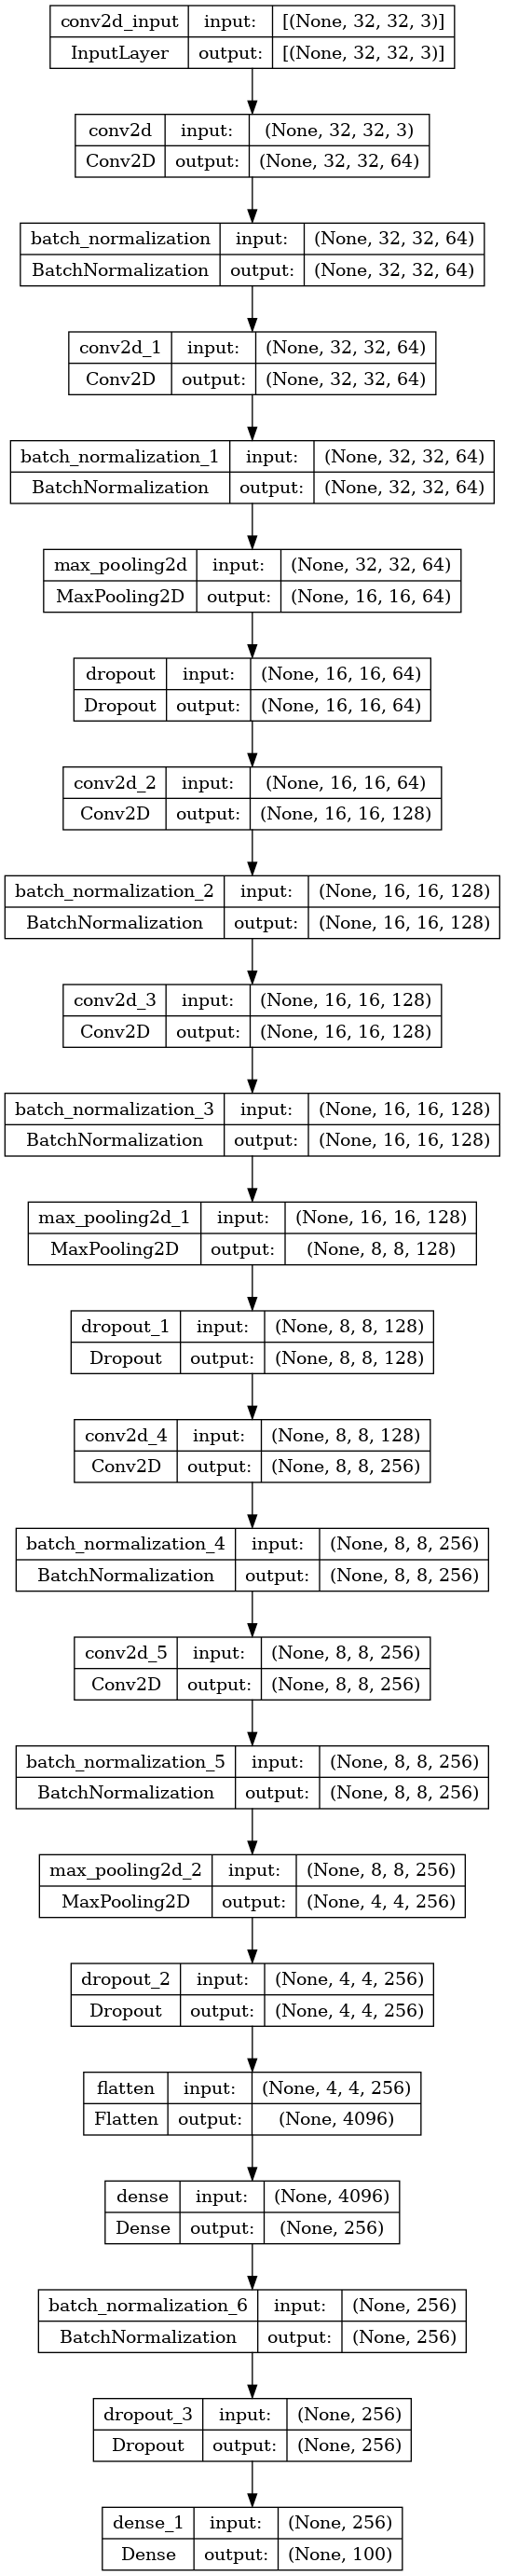

In [17]:
if not keras_tuning:
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    utils.plot_model(model, show_shapes=True, to_file='model.png', show_layer_names=True)
    img = Ipy.Image(filename='model.png')
    Ipy.display(img)


### Step 5: Training the Model

Epoch 1/50
781/781 [==============================] - 70s 73ms/step - loss: 4.1254 - accuracy: 0.0996 - val_loss: 3.4505 - val_accuracy: 0.1687
Epoch 2/50
781/781 [==============================] - 46s 59ms/step - loss: 3.2375 - accuracy: 0.2129 - val_loss: 2.9478 - val_accuracy: 0.2742
Epoch 3/50
781/781 [==============================] - 49s 63ms/step - loss: 2.8004 - accuracy: 0.2896 - val_loss: 2.3494 - val_accuracy: 0.3842
Epoch 4/50
781/781 [==============================] - 46s 59ms/step - loss: 2.5579 - accuracy: 0.3383 - val_loss: 2.3104 - val_accuracy: 0.3921
Epoch 5/50
781/781 [==============================] - 47s 60ms/step - loss: 2.3821 - accuracy: 0.3756 - val_loss: 2.2699 - val_accuracy: 0.4023
Epoch 6/50
781/781 [==============================] - 46s 59ms/step - loss: 2.2355 - accuracy: 0.4079 - val_loss: 1.9463 - val_accuracy: 0.4791
Epoch 7/50
781/781 [==============================] - 46s 58ms/step - loss: 2.1439 - accuracy: 0.4281 - val_loss: 1.9047 - val_accuracy:

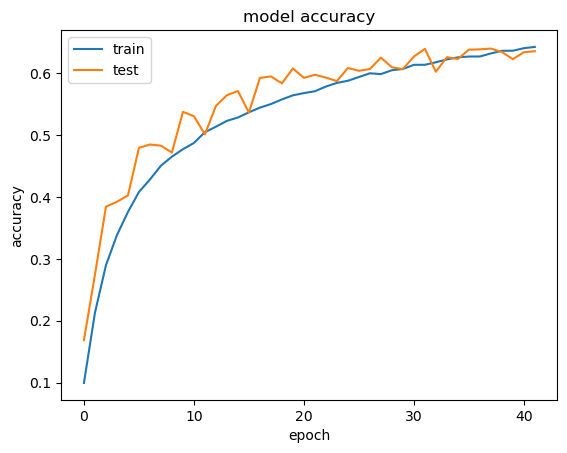

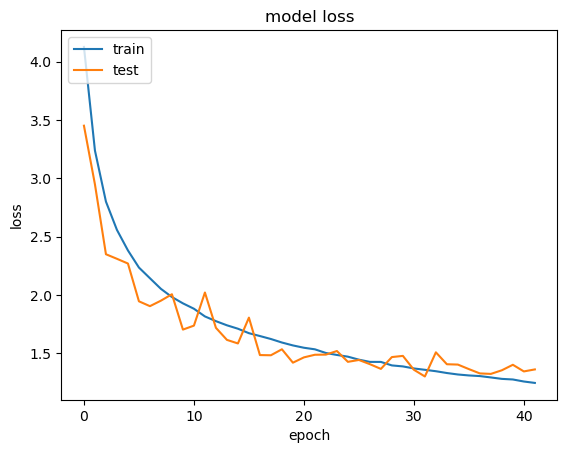

In [18]:
with strategy.scope():
    epochs = 50
    batch_size = 64
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
    model = build_model()
    # Adjust optimizer for mixed precision training
    opt = optimizers.Adam(learning_rate=0.001)
    #opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)
    
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        data_gen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(x_train) / batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=[early_stopping]
    )

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Step 6: Evaluate the Model

In [19]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

313/313 [==============================] - 3s 9ms/step - loss: 1.3628 - accuracy: 0.6352
Test Accuracy: 63.52%


### Step 7: Fine-tuning